In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Cropping2D
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

Using TensorFlow backend.


In [19]:
correction = 0.2 # this is a parameter to tune
del_rate = 0.8 #0.7
cut_value = 0.85

In [20]:
samples = []
with open("./data/driving_log.csv") as csvfile:
	reader  = csv.reader(csvfile)
	for sample in reader:
		samples.append(sample)
		
del(samples[0]) # delete the first row of column names
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)	

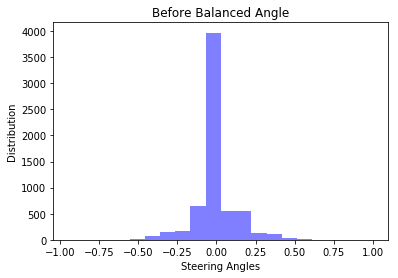

In [18]:
angles_b4balanced = []
for train_sample in train_samples:
    source_path = train_sample[0]
    filename = source_path.split('/')[-1]
    current_path = './data/IMG/' + filename
    image = cv2.imread(current_path)
    angle = float(train_sample[3])
    angles_b4balanced.append(angle)

#Histogram before balanced steering anlge---------------------------------------------------------------
num_bins = 20
n, bins, patches = plt.hist(angles_b4balanced, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Steering Angles')
plt.ylabel('Distribution')
plt.title('Before Balanced Angle')
plt.show()	

In [21]:
def RandomBrightness(image):
    # convert to HSV so that its easy to adjust brightness
    RandomImage = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # define boundary so that its not all dark or bright
    random_bright = np.random.uniform(0.25, 1)

    # Apply the brightness reduction to the V channel
    RandomImage[:,:,2] = RandomImage[:,:,2]*random_bright

    # convert to RBG again
    RandomImage = cv2.cvtColor(RandomImage,cv2.COLOR_HSV2RGB)
    return RandomImage

In [22]:
def generator(samples, batch_size=32):
	num_samples = len(samples)
	
	while 1: # Loop forever so the generator never terminates
		random.shuffle(samples)
		for offset in range(0, num_samples, batch_size):
			batch_samples = samples[offset:offset+batch_size]
			images = []
			steerings = []	
		
			for batch_sample in batch_samples:
				for i in range(3):
					source_path = batch_sample[i]
					filename = source_path.split('/')[-1]
					current_path = './data/IMG/' + filename
					image = cv2.imread(current_path)
					image = RandomBrightness(image) # random brightness
					
					if i == 0:
						steering = float(batch_sample[3])
					elif i == 1:
						steering = float(batch_sample[3]) + correction # Left
					else:
						steering = float(batch_sample[3]) - correction # Right
			
		
					if abs(steering) > cut_value: 
			
						images.append(image)
						steerings.append(steering)
						image_flipped = np.fliplr(image)
						steering_flipped = -steering
						images.append(image_flipped)
						steerings.append(steering_flipped)
			
					elif np.random.random() > del_rate: #delete % of low angle data and duplicate number of images
			
						images.append(image)
						steerings.append(steering)
						image_flipped = np.fliplr(image)
						steering_flipped = -steering
						images.append(image_flipped)
						steerings.append(steering_flipped)

		    	# trim image to only see section with road
			X_train = np.array(images)
			y_train = np.array(steerings)
			yield shuffle(X_train, y_train)

In [23]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

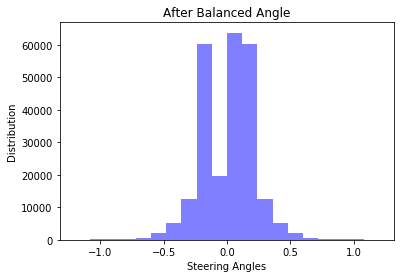

In [24]:
#Histogram after balanced steering angle---------------------------------------------------------------
angles = np.array([], dtype=np.float32)
for i in range(len(train_samples)):
    X_batch, y_batch = next(train_generator)
    angles = np.concatenate((angles, y_batch))

num_bins = 20
n, bins, patches = plt.hist(angles, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Steering Angles')
plt.ylabel('Distribution')
plt.title('After Balanced Angle')
plt.show()

In [42]:
#NVIDIA Model-----------------------------------------------------------------------------------------
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape = (160,320,3))) # image normalization
model.add(Cropping2D(cropping = ((50,20), (0,0)), input_shape = (160,320,3)))
# start adding other model layers here.

#Convolution:
model.add(Conv2D(24, 5, 5, activation = 'relu'))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Convolution:
model.add(Conv2D(36, 5, 5, activation = 'relu'))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Convolution:
model.add(Conv2D(48, 3, 3, activation = 'relu'))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Convolution:
model.add(Conv2D(64, 3, 3, activation = 'relu'))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Flatten:
model.add(Flatten())
#Fully Connected:
model.add(Dense(1164))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

In [43]:
#Training----------------------------------------------------------------------------------------------
model.compile(loss = 'mse', optimizer = 'adam')
#model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)
#model.fit_generator(train_generator, samples_per_epoch = len(train_samples), validation_data = validation_generator, nb_val_samples = len(validation_samples), nb_epoch = 5)
model.fit_generator(train_generator, samples_per_epoch = len(train_samples),validation_data = validation_generator, nb_val_samples = len(validation_samples), nb_epoch = 5, verbose = 1)

Epoch 1/5
6408/6428 [============================>.] - ETA: 0s - loss: 0.0576

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6440/6428 [==============================] - 49s - loss: 0.0574 - val_loss: 0.0248
Epoch 2/5
6440/6428 [==============================] - 48s - loss: 0.0250 - val_loss: 0.0293
Epoch 3/5
6440/6428 [==============================] - 47s - loss: 0.0237 - val_loss: 0.0286
Epoch 4/5
6428/6428 [==============================] - 48s - loss: 0.0211 - val_loss: 0.0277
Epoch 5/5
6442/6428 [==============================] - 47s - loss: 0.0221 - val_loss: 0.0208


In [44]:
#Save the model----------------------------------------------------------------------------------------
model.save('model.h5')

In [45]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 160, 320, 3)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
cropping2d_4 (Cropping2D)        (None, 90, 320, 3)    0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 86, 316, 24)   1824        cropping2d_4[0][0]               
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 43, 158, 24)   0           convolution2d_13[0][0]           
___________________________________________________________________________________________

In [46]:
from keras.utils.visualize_util import plot
from keras.models import load_model

#visualize the model
modelobj = load_model('model.h5')
plot (modelobj, to_file='model.png')